In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Define the transforms to apply to the images
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the pixel values
])


In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to (224, 224)
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the pixel values
])

In [ ]:
# Define the training dataset
train_dataset = datasets.ImageFolder("/content/drive/MyDrive/minor_project/known_faces", transform=train_transform)
test_dataset = datasets.ImageFolder("/content/drive/MyDrive/minor_project/unknown_faces", transform=test_transform)



# Define the DataLoader to load the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
# Define the DataLoader to load the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Define the model architecture
class FaceRecognizer(nn.Module):
    def __init__(self, num_classes=3):
        super(FaceRecognizer, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
# Define the device to train on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define the model and move it to the device
model = FaceRecognizer(num_classes=len(train_dataset.classes)).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Move the data and targets to the device
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {loss:.4f}")

KeyboardInterrupt: ignored

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store ground truth labels and predicted labels
true_labels = []
predicted_labels = []

# Deactivate gradient computation to speed up inference
with torch.no_grad():
    # Iterate over the test dataset
    for images, labels in test_loader:
        # Move the data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get the predicted labels
        _, predicted = torch.max(outputs.data, 1)

        # Store the true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

distinct_values = list(set(predicted_labels))
value_map = {val: i for i, val in enumerate(sorted(distinct_values))}
reset_lst = [value_map[val] for val in predicted_labels]
#print(reset_lst)
# Calculate the accuracy score
accuracy = accuracy_score(true_labels, reset_lst)
print(true_labels,reset_lst)
# Print the accuracy score
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

[0, 0, 1, 2, 3, 3, 4, 4, 4, 4, 5, 6, 7, 8, 8, 8, 9, 9, 9] [0, 0, 1, 2, 3, 3, 4, 4, 4, 4, 5, 6, 7, 8, 8, 8, 10, 11, 9]
Test Accuracy: 89.47%


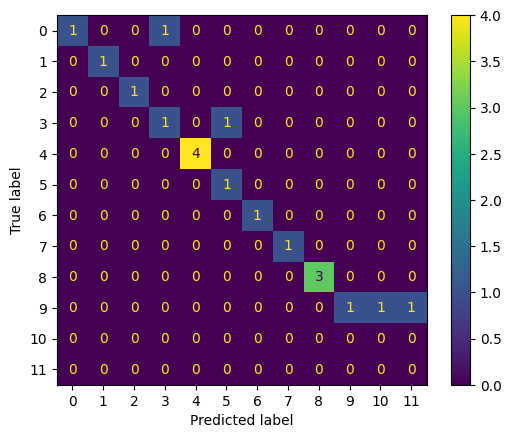

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(true_labels, reset_lst)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/My Drive/face_recognizer_model.pth')

In [ ]:
num_classes=len(train_dataset.classes)
model = FaceRecognizer(num_classes).to(device)
#loading model with gpu and cpu

# load the saved model weights
checkpoint = torch.load('/content/drive/MyDrive/face_recognizer_model.pth')
model.load_state_dict(checkpoint, strict=False)

RuntimeError: ignored

In [ ]:
num_classes=len(train_dataset.classes)
model = FaceRecognizer(num_classes).to(device)
# loading model without gpu directly on cpu

# load the saved model weights
checkpoint = torch.load('/content/drive/MyDrive/face_recognizer_model.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint, strict=False)

<All keys matched successfully>